In [1]:
import time
from pathlib import Path
import matplotlib.pyplot as plt
import torch
import sys
sys.path.append("..")
from data_loader.kitti_odometry_dataset import KittiOdometryDataset
from model.monorec.monorec_model import MonoRecModel
from utils import unsqueezer, map_fn, to

In [2]:
# 0. 准备工作
target_image_size = (256, 512) # 测试图片大小; 原始大小为(370,1226)

device = "cuda:0" if torch.cuda.is_available() else "cpu"

dataset = KittiOdometryDataset("data/kitti", sequences=["07"], target_image_size=target_image_size, frame_count=2,
                               depth_folder="image_depth_annotated", lidar_depth=True, use_dso_poses=True,
                               use_index_mask=None)

In [6]:
# Next three lines are a hack required because Kitti files are incomplete
dataset._dataset_sizes = [1000]
dataset._datasets[0].cam2_files = [f"data/kitti/sequences/07/image_2/{i:06d}.png" for i in range(dataset._dataset_sizes[0])] # 'data/kitti/sequences/07/image_2/0~999.png'
dataset._datasets[0].cam3_files = [f"data/kitti/sequences/07/image_3/{i:06d}.png" for i in range(dataset._dataset_sizes[0])]

## 设置pretrained model位置
checkpoint_location = Path("../saved/checkpoints/monorec_depth_ref.pth")

## 定义inv depth范围
inv_depth_min_max = [0.33, 0.0025]  # 正常的depth range3～400

## 加载pretrained model
print("Initializing model...")
monorec_model = MonoRecModel(checkpoint_location=checkpoint_location, inv_depth_min_max=inv_depth_min_max)
monorec_model.to(device)
monorec_model.eval()

Initializing model...


MonoRecModel(
  (_feature_extractor): ResnetEncoder(
    (encoder): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    

In [7]:
print("Fetching data...")
index = 164
# Corresponds to image index 169

batch, depth = dataset.__getitem__(index)

Fetching data...


In [13]:
for i in batch.keys():
    print(i)

keyframe
keyframe_pose
keyframe_intrinsics
frames
poses
intrinsics
sequence
image_id


In [30]:
# print(batch["keyframe"].shape)
# print(batch["keyframe_pose"])
# print(batch["keyframe_intrinsics"])
# print(batch["frames"][0].shape)
# print(batch["poses"][0])
# print(type(batch["intrinsics"]))
# print(batch["sequence"])
# print(batch["image_id"])

tensor([169], dtype=torch.int32)


In [31]:
print(depth.shape)

torch.Size([1, 256, 512])


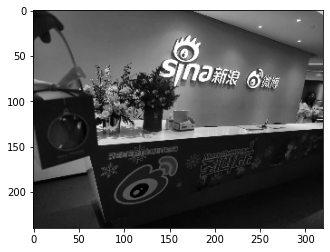

In [54]:
img0 = cv2.resize(b, (320,240))
plt.imshow(img0,"gray")

In [92]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
MIN_MATCH_COUNT = 10
img1 = img0
img2 = img1
# Initiate SIFT detector
sift = cv.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1,des2,k=2)
# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()

In [95]:
len(matchesMask)

367

In [84]:
sift = cv2.SIFT_create()
kp1, desc1 = sift.detectAndCompute(img0,None)
# for i in kp1
# i.pt 特征点的位置，以tuple形式存在。但是是小数
# i.response
# i.size 代表着scale neigor信息是多大范围的
type(kp1[0].response)

float

In [59]:
def generate_map(img0):
    # 1. 生成map 模版
    H,W = img0.shape
    D = 128 # sift 产生128维的desc
    prob = np.zeros((H,W))
    keypoint = np.zeros((H,W))
    desc = np.zeros((H,W,D))
    
    
    # 2. 提取特征点
    sift = cv2.SIFT_create()
    kpt1, desc1 = sift.detectAndCompute(img0,None) # kp1 - list n个keypoint obj; desc1 - ndarray (n,128d)
    
    # 生成map
    for i in range(len(kp1)):
        coor = kpt1[i].pt
        x = int(coor[1])
        y = int(coor[0])
        prob[x,y] = float(kpt1[i].response)
        keypoint[x,y] = 1
        desc[x,y,:] = desc1[i,:]
    
    return {
        "prob": prob,
        "keypoint": keypoint,
        "desc": desc
    }

In [63]:
dict1 = generate_map(img0)
prob = dict1["prob"]
keypoint = dict1["keypoint"]
desc = dict1["desc"]

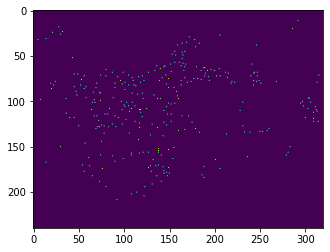

In [81]:
plt.imshow((keypoint*255.0).astype(np.uint8))

In [78]:
drawimg = cv2.cvtColor(img0.copy(), cv2.COLOR_GRAY2BGR)
for i in kp1:
    coor = i.pt
    cv2.circle(drawimg, (int(coor[0]),int(coor[1])), radius=1, color=(255,0,0), thickness=1, lineType=8)

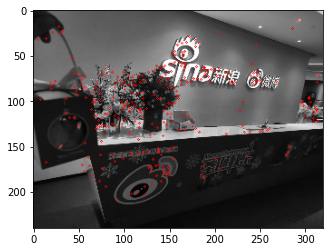

In [79]:
plt.imshow(drawimg)

In [ ]:
def kpt2map(kpt):
    '''
    Input:
        kpt: cv2.keypoint
    Output:
        [H,W]
    '''
    
    
    return

In [91]:
# 0. 创建BFMatcher对象
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

In [92]:
# 1. 两组descriptor
desc = np.random.randn(100,10).astype(np.uint8)
warped_desc = np.random.randn(100,10).astype(np.uint8)

In [93]:
# 2. 匹配
matches = bf.match(desc, warped_desc)

In [94]:
# 3. 根据distance排序matches
matches = sorted(matches, key = lambda x:x.distance) 

In [95]:
# 三种常见的键值
matches_idx = np.array([m.queryIdx for m in matches]) # 对应点在A图中的index
matches_dis = np.array([m.distance for m in matches]) # 匹配的对应点的L2距离
matches_tidx = np.array([m.trainIdx for m in matches]) # 对应点在B图中的index

In [100]:
print(matches_idx)
print(len(matches_idx))

[14 27 39 44 51 62 90 24 63 76 80 98 32 56 65 66 70  7 13 37  4 79 43 82
 38 36 23 89 95  8 81]
31


In [101]:
print(matches_dis)
print(len(matches_dis))

[  0.           0.           0.           0.           0.
   0.           0.           1.           1.           1.
   1.           1.           1.41421354   1.41421354   1.41421354
   1.41421354   1.41421354   1.73205078   1.73205078   1.73205078
   2.           2.           2.23606801   2.23606801   2.44948983
   2.64575124   2.82842708 253.00198364 253.00198364 254.00393677
 254.02165222]
31


In [102]:
print(matches_tidx)
print(len(matches_tidx))

[21  0 48 28 62 68 59 92 87 71  7  1 24 17 66 27 83 12 46 95 42 43 57 47
 15 79 41 94 23  6 26]
31


In [82]:
a = np.ones(4)

In [87]:
s = float(np.mean(a<=2))

In [90]:
a = np.random.randn(2,3,4)

In [93]:
a.ndim

3

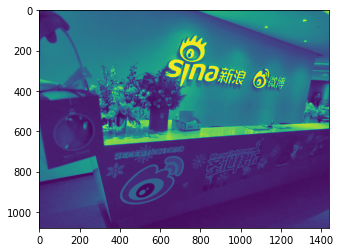

In [109]:
img = cv2.imread('./1.jpeg',cv2.IMREAD_GRAYSCALE)
plt.imshow(img)

In [110]:
# Initiate ORB detector
orb = cv2.ORB_create()
# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img,None)

In [113]:
kp1

AttributeError: 'list' object has no attribute 'shape'

In [29]:
for i in range(8):
    if i<6:
        pass
    else:
        continue
    print(i)

0
1
2
3
4
5


In [30]:
a = torch.rand(8,256,1,1,30,40)

In [31]:
b = torch.rand(8,256,30,40,1,1)

In [32]:
a*b

KeyboardInterrupt: 

In [34]:
torch.sum(b,dim=1).shape

torch.Size([8, 30, 40, 1, 1])

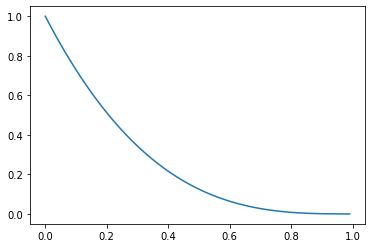

In [39]:
x = np.arange(0, 1, 0.01)
y = (1-x)**3
plt.plot(x, y)

# 计算指标！

In [89]:
import numpy as np 
arr = [0.45, 1.138]
 
# 求均值
arr_mean = np.mean(arr)
 
# 求方差
arr_var = np.var(arr)
 
# 求总体标准差
arr_std_1 = np.std(arr)
 
# 求样本标准差
arr_std_2 = np.std(arr, ddof=1)
 
print("平均值为：%f" % arr_mean)
print("方差为：%f" % arr_var)

平均值为：0.794000
方差为：0.118336


In [17]:
f1 = [0.792,0.572]
ma = [0.761,0.459]
mle = [0.496,1.113]

In [18]:
for i in range(len(f1)//2):
    arr = [f1[i*2],f1[i*2+1]]
    # 求均值
    arr_mean = np.mean(arr)

    # 求方差
    arr_var = np.var(arr)
    print("f1: mean",arr_mean, "std: ", arr_var)

f1: mean 0.6819999999999999 std:  0.01210000000000001


In [19]:
for i in range(len(ma)//2):
    arr = [ma[i*2],ma[i*2+1]]
    # 求均值
    arr_mean = np.mean(arr)

    # 求方差
    arr_var = np.var(arr)
    print("ma: mean",arr_mean, "std: ", arr_var)

ma: mean 0.61 std:  0.022801


In [20]:
for i in range(len(mle)//2):
    arr = [mle[i*2],mle[i*2+1]]
    # 求均值
    arr_mean = np.mean(arr)

    # 求方差
    arr_var = np.var(arr)
    print("mle: mean",arr_mean, "std: ", arr_var)

mle: mean 0.8045 std:  0.09517225


In [108]:
pred = np.array([[0,1],
               [0,2],
               [0,3]])
gt = np.array([[1,1],
              [1,2]])

In [109]:
diff = np.expand_dims(pred, axis=1) - np.expand_dims(gt, axis=0)      # (N1,1,2) - (1,N2,2)   -> (N1,N2,2) 两两点之间的差
# 欧氏距离差
dist = np.linalg.norm(diff, axis=-1)

In [111]:
matches = np.less_equal(dist, 2)

In [114]:
matches

array([[ True,  True],
       [ True,  True],
       [False,  True]])

In [116]:
for i in matches:
    print(i)

[ True  True]
[ True  True]
[False  True]


In [2]:
(0.20+0.016)*40

8.64

In [4]:
0.2/5000

4e-05

In [ ]:
np.expand_dims()

In [18]:
list1 = []
list2 = []
for i in range(200):
    fz = (65**(0.55*i)) * (35**(0.45*i))
    fm = 65**(0.55*i) * 35**(0.45*i) + 45**(0.55*i) * 55**(0.45*i)
    p = fz/fm
    list1.append(p)
    
    fz1 = (9/13)**(0.1*i)
    fm1 = (99/91)**(0.45*i)
    p1 = fz1*fm1
    list2.append(p1)

In [25]:
list2

[1.0,
 1.001145332007775,
 1.002291975800958,
 1.003439932881979,
 1.0045892047549887,
 1.0057397929258596,
 1.0068916989021905,
 1.0080449241933063,
 1.00919947031026,
 1.010355338765836,
 1.011512531074551,
 1.0126710487526562,
 1.0138308933181397,
 1.0149920662907284,
 1.0161545691918887,
 1.017318403544831,
 1.0184835708745097,
 1.0196500727076252,
 1.0208179105726274,
 1.0219870859997162,
 1.0231576005208445,
 1.0243294556697196,
 1.0255026529818048,
 1.026677193994323,
 1.0278530802462573,
 1.0290303132783536,
 1.0302088946331223,
 1.03138882585484,
 1.0325701084895529,
 1.0337527440850778,
 1.0349367341910038,
 1.036122080358695,
 1.0373087841412922,
 1.0384968470937153,
 1.0396862707726653,
 1.0408770567366257,
 1.0420692065458648,
 1.0432627217624386,
 1.0444576039501916,
 1.0456538546747596,
 1.046851475503572,
 1.0480504680058527,
 1.0492508337526236,
 1.0504525743167052,
 1.0516556912727197,
 1.0528601861970932,
 1.0540660606680563,
 1.0552733162656494,
 1.056481954571719,


In [23]:
13/9*7/11

0.9191919191919191

In [3]:
(13**0.55)*(7**0.45)/((9**0.55)*(11**0.45))

0.998855978276922